In [37]:
import numpy as np
import numpy.matlib
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time
from sklearn.linear_model import Ridge
from random import randint


In [38]:
from keras.datasets import mnist

Given code
-----------


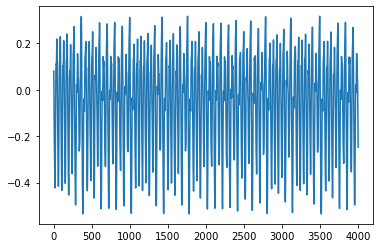

In [39]:

# check for intuition at  http://users.fs.cvut.cz/ivo.bukovsky/PVVR/prace_studentu/Mackey_Glass_time_series_prediction_Fuzzy_Lookup.pdf

def mackey_glass(tau, length):
    betta=0.2
    gamma = 0.1 
    a=10
    delay=100 # will cut these initial steps
    
    y=np.random.rand(tau) # random intial values between 0 and 1
    # Euler's method to solve the differential equation
    for t in range(tau-1, length+delay+tau-1):
        current= y[t] + ( betta * y[t-(tau-1)]   / ( 1 + np.power(y[t-(tau-1)], a) 
)  ) - gamma*y[t]   
        y=np.append(y, current)
    
    y=y-1 # get rid of mean
    y=np.tanh(y) # squeze with tanh    
    
    return y[tau+delay:length+delay+tau] # return the last length elements
length=4000 # duration of the series
tau=17 # delay in the equation
y=mackey_glass(tau, length)
#plot generated time-series
plt.plot(y)
plt.show()

part 1:
-----


Generate a sequence for 4,000 time steps; n is in the range between 1 and 4,000

In [40]:
def generateSequence(parameters):
    valueArray = []
    for n in range(parameters[0],parameters[1]+1):
        value = 0.5 * math.sin(n/4)
        valueArray.append(value) 
    return(valueArray)

In [41]:
rangeParameters = [1, 4000] 
dataValues = generateSequence(rangeParameters)
print(len(dataValues))


4000


Part 2:
------------
Take the first 3,000 steps for the training and leave the last 1,000 steps forthe testing

In [42]:
def splitArrayTwo(array, firstLength):
    firstArray = array[:firstLength]
    secoundArray = array[firstLength:]
    firstArray = np.array(firstArray)
    secoundArray = np.array(secoundArray)
    return firstArray, secoundArray


In [43]:
train_Data , test_Data = splitArrayTwo(dataValues,3000)
print(len(train_Data), len(test_Data))

3000 1000


Part 3:
--------
Fix the reservoir size to Nx = 1,000 neurons

In [44]:
reservoirSize = 1000

Part 4:
---------
 Generate input weight matrix Win from uniform distribution between -1 and 1. Scale Win by 0.2.

In [62]:
scale = 0.2
weight_min = -1
weight_max = 1
weight_in = np.random.uniform(weight_min,weight_max,(reservoirSize,2))*scale
W = np.random.uniform(weight_min,weight_max,(reservoirSize,reservoirSize))*scale
print(weight_in.shape)


(1000, 2)


Part 5:
------------
Do not forget to add a bias input neuron, which constantly feeds 1 to the reservoir.

In [46]:
bias = 1
reservoir = reservoirSize + bias

Part 6:
---------
Set the spectral radius (feedback strength) for the reservoir connection matrix to ρ = 0.8. 


In [53]:
spectralRadius  = 0.8
vall = np.abs(np.linalg.eigvals(W))
W_res = W/(max(vall))*spectralRadius

Part 7:
----------
Feed-in ground truth-values of the signal to the ESN during the training.


In [85]:
def training(training_set):
    W_in = 0
    W_out = 0
    x =  0
    y = 0
    return (W_in,W_out, x, y)

def ESN(test_Data, W_in,W_out, x, y):

    print("ESN")


W_in,W_out, x, y = training(train_Data)
ESN(test_Data, W_in,W_out, x, y)    # page 5 in catagori 3.2.4

ESN


Part 8:
-----------
For time step n the teaching forcing signal is the value of the signal at 
time step n+1, i.e., y(n+1)

In [88]:
def training(training_set):
    W_out = np.random.uniform(weight_min,weight_max,(1,(reservoirSize+1+1)))*scale
    W_back = np.random.uniform(weight_min,weight_max,(reservoirSize,1))*scale

    x = np.zeros(1000)
    y = np.zeros(1)
    y_res = []
    x_res = []

    print(training_set.shape)
    for n in range(1,2998):
        u = np.array([training_set[n],bias])
        
 
        part1 = np.dot(W_in,u)
        part2 = np.dot(W_res,x)
        part3 = np.dot(W_back,np.array([training_set[n-1]]).real)

        concatSum_x = np.concatenate([u,x]) #function 15 & 16 plus the informastion on the top of page 15


        x = np.tanh( part2 + part1 + part3).real
        y = np.array(math.tanh(np.dot(W_out,concatSum_x)).real)


        y_target = np.array([training_set[n+1]]).real
        

        y_res.append(y_target)
        x_res.append(concatSum_x)

    return (W_in,W_back, x, y)

def ESN(test_Data, W_in,W_back, x, y):


    for n in range(1,2998):
        u = np.array([test_Data[n],bias])

        part1 = np.dot(W_in,u) 
        part2 = np.dot(W,x)
        part3 = np.dot(W_back,y)

        x = math.tanh(part1 + part2 + part3)
    print("ESN")


W_in,W_back, x, y = training(train_Data)
ESN(test_Data, W_in,W_back, x, y)

(3000,)


ValueError: operands could not be broadcast together with shapes (1000,) (2,) 